In [1]:
#usefull libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
import missingno as msno
#https://www.kaggle.com/code/residentmario/using-missingno-to-diagnose-data-sparsity/notebook
plt.style.use('seaborn')
import nltk
from nltk.corpus import stopwords
# color palette
purple="#f862c6"
blue="#b7fdfe"
green="#5ef38c"
yellow="#f8e858"
red="#f85263"
palette=[red,green,yellow,purple,blue]

In [2]:
#import the data
train_data=pd.read_csv('data/Corona_NLP_train.csv',encoding='latin1')
test_data=pd.read_csv('data/Corona_NLP_test.csv',encoding='latin1')

## Multiclass classification
### An example using tweets about COVID-19
Multiclass classification in Machine Learning is a task related to classificate data with labels belonging to a set of two or more cathegories or classes. For the specific case of two cathegories, the task is also known as *Binary Classification*

We obtained a dataset of tweets in English from [Kaggle](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification) where each tweet was tagged with one of the following sentiment labels: *Extremly Negative, Negative, Neutral, Positive and Extremly Positive*. Our aim is give a description about the dataset and perform a usefull multiclass classification using a dense neural network.

### A first look to data
The Kaggle's dataset is composed by two csv files. One of them for train the model and the second one for test the model. We have six columns who contains the next cathegories:
- UserName (encoded)
- ScreenName
- Location
- Date
- Tweet
- Label

In [3]:
print("Shape of train data: ", train_data.shape)
print("Shape of test data: ", test_data.shape)
data=pd.concat([train_data,test_data])
print("Total data: ", data.shape)

Shape of train data:  (41157, 6)
Shape of test data:  (3798, 6)
Total data:  (44955, 6)


In [4]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


We have no interest in the UserName and ScreenName columns, so we'll drop the columns. Also we seek duplicate tweets and NaN values.

Shape after drop duplicates and useless columns (44955, 4)
NaN in data represented by white lines:


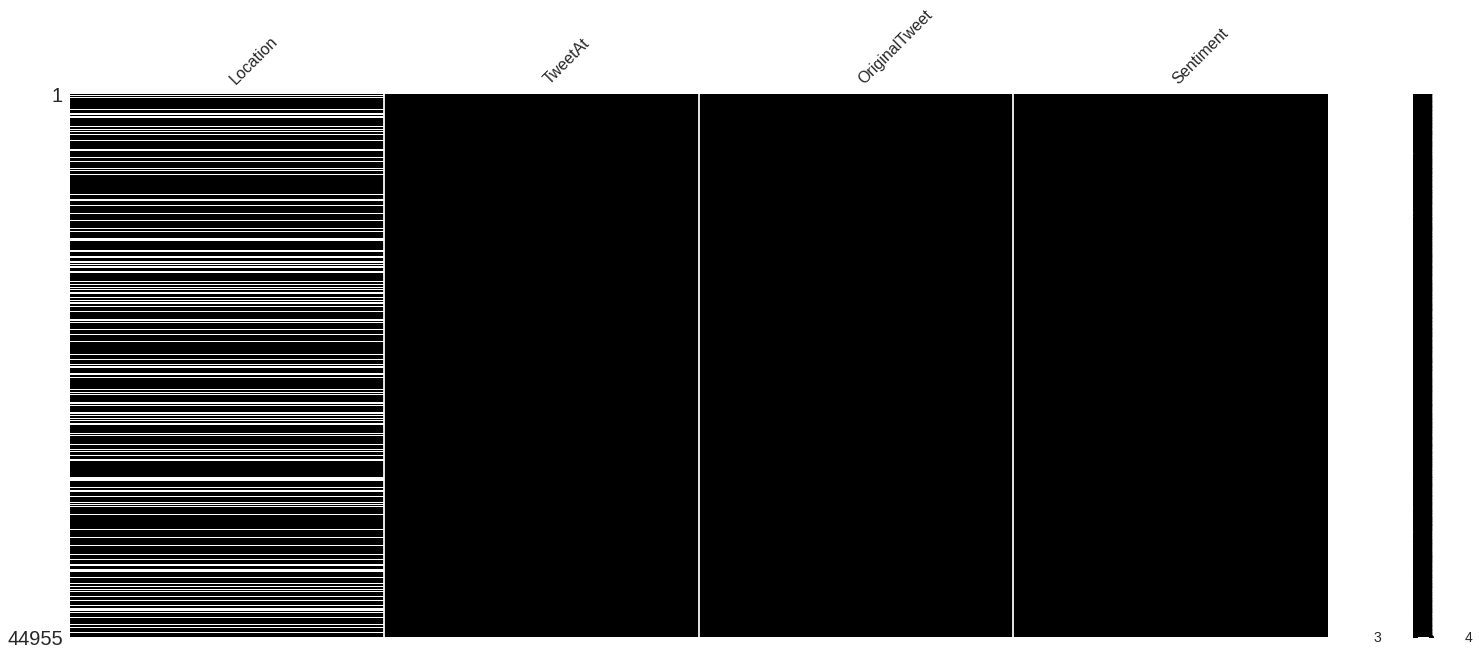

In [6]:
train_data=train_data.drop(columns=['UserName', 'ScreenName'])
test_data=test_data.drop(columns=['UserName', 'ScreenName'])
data=data.drop(columns=['UserName', 'ScreenName'])
data=data.drop_duplicates()
print("Shape after drop duplicates and useless columns", data.shape)
msno.matrix(data, color=(0.0,0.0,0.0))
print("NaN in data represented by white lines:")

As we can see, we don't have any duplicated values in test and train data and we only have NaN in Location column. So its no necessary to aply any further filter.
Due this, we choose don't take any analysis about tweets, labels and Location.

Now let's take a look to the labels

Labels:  ['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Counts for label
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


<AxesSubplot:title={'center':'Class distribution'}, ylabel='Sentiment'>

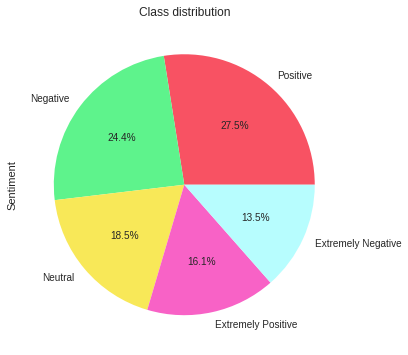

In [44]:
print("Labels: ", data.Sentiment.unique())
print("Counts for label")
print(data.Sentiment.value_counts())
data.Sentiment.value_counts().plot(kind='pie',title='Class distribution',autopct='%1.1f%%',colors=palette, figsize=(9,6))

We have a majority in Negative and Positive tweets, in many analysis about this dataset people choose merge the negative and extremly negative labels and positive with extremly positive tags. We wont follow this approach beacuse this left a notable minority in Neutral labels, and a further analysis about the validation of the model must be followed. We talk more about this when we setting the model.

### About the tweets
Lets extract some information about the tweets like number of words, hashtags and the common words for each tag.

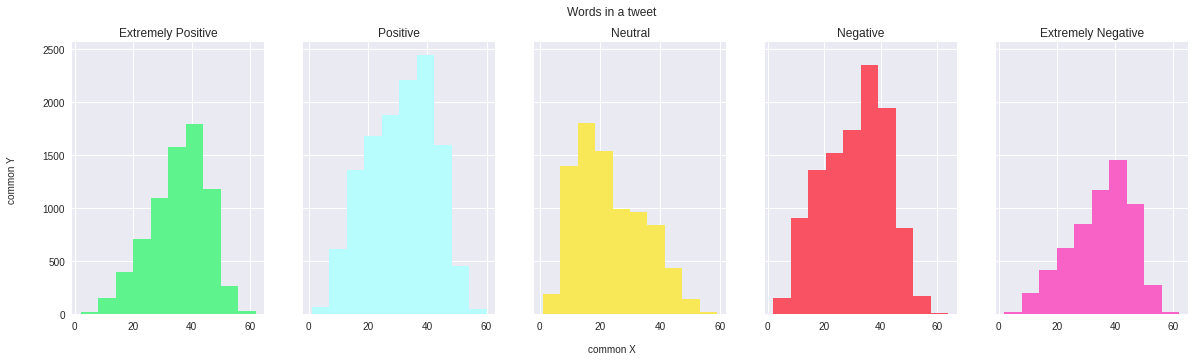

In [8]:
#https://j2logo.com/python/funciones-lambda-en-python/
fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,figsize=(20,5),sharey=True)

words=data[data['Sentiment']=="Extremely Positive"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax1.hist(words,color=green)
ax1.title.set_text('Extremely Positive')

words=data[data['Sentiment']=="Positive"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax2.hist(words,color=blue)
ax2.title.set_text('Positive')

words=data[data['Sentiment']=="Neutral"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax3.hist(words,color=yellow)
ax3.title.set_text('Neutral')

words=data[data['Sentiment']=="Negative"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax4.hist(words,color=red)
ax4.title.set_text('Negative')

words=data[data['Sentiment']=="Extremely Negative"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax5.hist(words,color=purple)
ax5.title.set_text('Extremely Negative')

fig.suptitle('Words in a tweet')
fig.text(0.5, 0.02, 'common X', ha='center')
fig.text(0.08, 0.5, 'common Y', va='center', rotation='vertical')
plt.show()

As we can see, people tend to write more when tweets are no neutral. Maybe exposing opinions, personal situations and experiences during pandemic. We'll see the most frecuent words used in each class as well as in general.

First of all, we need to remove the stopwords

In [9]:
#stopwords from ntlk
stop = set(stopwords.words('english'))
# from all the tweets
words=data['OriginalTweet'].str.split()
def common_words(words):
    new_row=[]
    for word in words: 
        if word not in stop:
            new_row.append(word)
    return new_row
# remember: map(function, input)
data['Filter words']=list(map(common_words,words))
# a new column is created, Filter words

This is a prototype, so here we put all the plots

Text(0.5, 0, 'common xlabel')

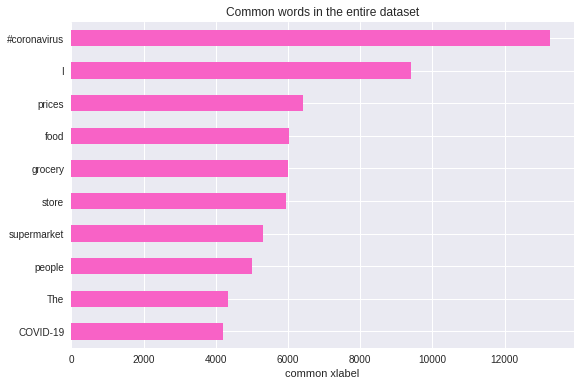

In [43]:
# common words for each class
bag_of_words=[]
for list in data['Filter words']:
    bag_of_words.extend(list)
countdata=pd.value_counts(np.array(bag_of_words))
ax=countdata[:10].plot(kind='barh',color=purple,title="Common words in the entire dataset", figsize=(9,6))
ax.invert_yaxis()
ax.set_xlabel('common xlabel')

Text(0.5, 0, 'common xlabel')

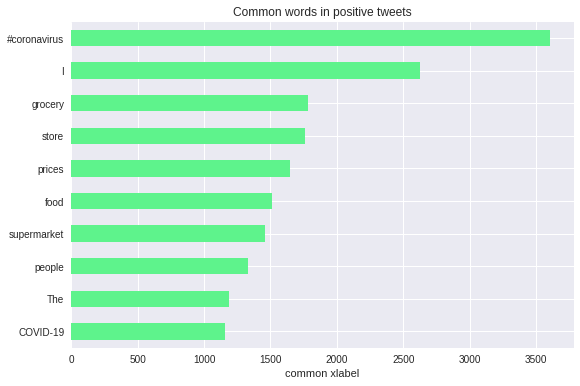

In [42]:
# common words for each class
bag_of_words=[]
for list in data[data['Sentiment']=="Positive"]['Filter words']:
    bag_of_words.extend(list)
countdata=pd.value_counts(np.array(bag_of_words))
ax=countdata[:10].plot(kind='barh',color=green,title="Common words in positive tweets",figsize=(9,6))
ax.invert_yaxis()
ax.set_xlabel('common xlabel')

Text(0.5, 0, 'common xlabel')

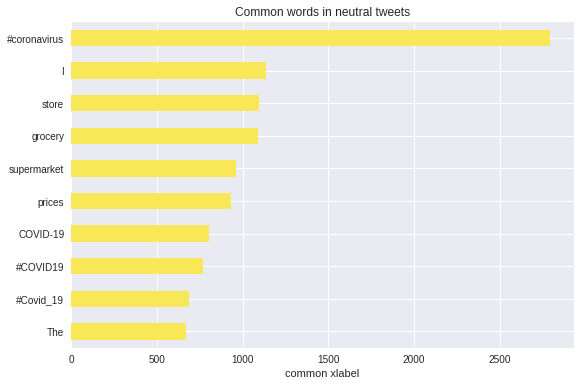

In [41]:
# common words for each class
bag_of_words=[]
for list in data[data['Sentiment']=="Neutral"]['Filter words']:
    bag_of_words.extend(list)
countdata=pd.value_counts(np.array(bag_of_words))
ax=countdata[:10].plot(kind='barh',color=yellow,title="Common words in neutral tweets", figsize=(9,6))
ax.invert_yaxis()
ax.set_xlabel('common xlabel')

Text(0.5, 0, 'common xlabel')

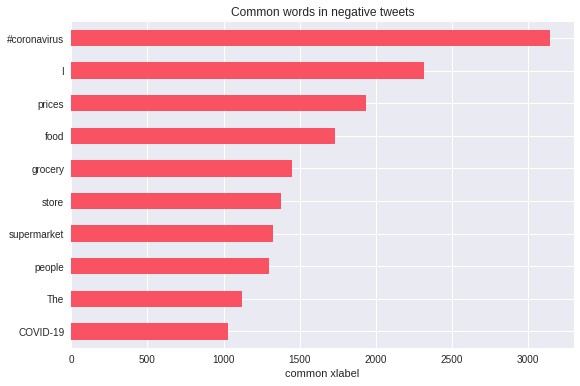

In [38]:
# common words for each class
bag_of_words=[]
for list in data[data['Sentiment']=="Negative"]['Filter words']:
    bag_of_words.extend(list)
countdata=pd.value_counts(np.array(bag_of_words))
ax=countdata[:10].plot(kind='barh',color=red,title="Common words in negative tweets", figsize=(9,6))
ax.invert_yaxis()
ax.set_xlabel('common xlabel')

The most common words are related to supermarkets and grocery stores. At the beggining of the pandemic one of the problems was the lack of blah blah blah... Let's take an analysis about the date of the tweets.

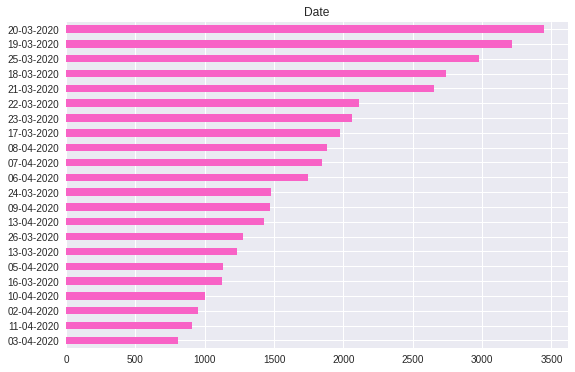

In [47]:
ax=data.TweetAt.value_counts()[:22].plot(kind='barh',title='Date',color=purple, figsize=(9,6))
ax.invert_yaxis()

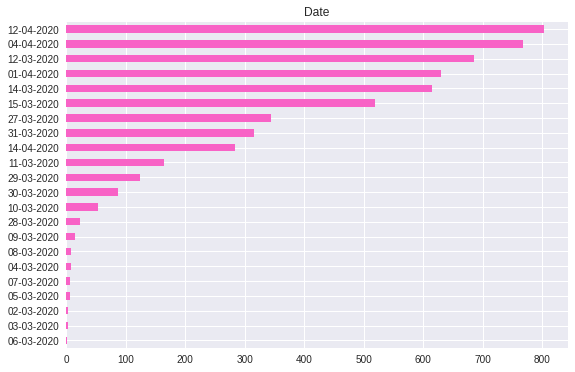

In [48]:
ax=data.TweetAt.value_counts()[22:].plot(kind='barh',title='Date',color=purple, figsize=(9,6))
ax.invert_yaxis()

The data was collected during the first months of the pandemic, according to la escases de insumos blah blah blah.